# Export variables from simulation output
- This script is used to export variables from simulations and calculate monthly mean and hourly mean values.
- Simulations: GM_SLUCM, GM_CLMU. 

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
home_path = "/gws/nopw/j04/duicv/yuansun/"

## GM_NOAH-SLUCM

In [56]:
start_time = pd.Timestamp('2022-01-01 00:00:00')
end_time = pd.Timestamp('2023-01-01 00:00:00')
station_list = ['hadisd', 'maqs', 'whitworth', 'sensor'] #
#indexlat_list = [7 , 17, 18, 19]
#indexlon_list = [28, 31, 30, 30]
indexlat_list = [9 , 17, 19, 21]
indexlon_list = [28, 31, 29, 30]
model_list = ['wrf', 'wrf-ctsm']
archive_path = home_path + '0_WRFvsWRF-CTSM/archive/'

In [3]:
def compute_rh2_from_wrf(Q2: xr.DataArray, T2: xr.DataArray, PSFC: xr.DataArray) -> xr.DataArray:
    # Convert T2 from Kelvin to Celsius

    # Saturation vapor pressure (hPa)
    es = 6.112 * np.exp((17.67 * T2) / (T2 + 243.5))

    # Actual vapor pressure (hPa), using PSFC (Pa)
    e = (Q2 * PSFC) / (0.622 + Q2) / 100  # Convert from Pa to hPa

    # Relative Humidity (%)
    RH2 = (e / es) * 100
    RH2 = RH2.clip(min=0, max=100)  # Ensure values are within 0-100%
    return RH2

In [125]:
def compute_rh_from_wrf(QVAPOR: xr.DataArray, T: xr.DataArray, P: xr.DataArray) -> xr.DataArray:
    # Convert T2 from Kelvin to Celsius

    # Saturation vapor pressure (hPa)
    es = 6.112 * np.exp((17.67 * T) / (T + 243.5))

    # Actual vapor pressure (hPa), using PSFC (Pa)
    Q = QVAPOR / (1 + QVAPOR)
    e = (Q * P) / (0.622 + Q) / 100  # Convert from Pa to hPa

    # Relative Humidity (%)
    RH = (e / es) * 100
    RH = RH.clip(min=0, max=100)  # Ensure values are within 0-100%
    return RH

In [126]:
for m, model in enumerate(model_list):
    model_archive_path = f'{archive_path}d04_{model}/'
    file_list = os.listdir(model_archive_path)
    nc_files = [f for f in file_list if f.endswith('.nc')]
    df_model = pd.DataFrame()
    for file in nc_files:
        ds_sim = xr.open_dataset(f'{model_archive_path}{file}')
        print(f'Processing {model} file: {file}')
        df_sim_station = pd.DataFrame()
        for i, station in enumerate(station_list):
            lat_idx = indexlat_list[i]
            lon_idx = indexlon_list[i]
            ds_sim_sel = ds_sim.sel(south_north=lat_idx, west_east=lon_idx, south_north_stag=lat_idx, west_east_stag=lon_idx)
            if station == 'whitworth':
                atmospheric_tem = ds_sim_sel['T'][:, 0]
                atmospheric_pressure = ds_sim_sel['P'][:, 0] + ds_sim_sel['PB'][:, 0]  # Total pressure in Pa
                atmospheric_vapor = ds_sim_sel['QVAPOR'][:, 0]
                atmospheric_u = ds_sim_sel['U'][:, 0]
                atmospheric_v = ds_sim_sel['V'][:, 0]
                ds_sim_tas = (300 + atmospheric_tem) * (atmospheric_pressure / 100000) ** 0.286 - 273.15
                ds_sim_rh = compute_rh_from_wrf(atmospheric_vapor, ds_sim_tas, atmospheric_pressure).rename('RH')
                ds_sim_wind = np.sqrt(atmospheric_u**2 + atmospheric_v**2).rename('WIND')
                df_sim_tas = ds_sim_tas.to_dataframe(name='TAS').reset_index()[['TAS', 'XTIME']].rename(columns={'XTIME': 'time'})
                df_sim_rh = ds_sim_rh.to_dataframe(name='RH').reset_index()[['RH', 'XTIME']].rename(columns={'XTIME': 'time'})
                df_sim_wind = ds_sim_wind.to_dataframe(name='WIND').reset_index()[['WIND', 'XTIME']].rename(columns={'XTIME': 'time'})
            else:
                ds_sim_tas = ds_sim_sel['T2'] - 273.15  
                ds_sim_q2 = ds_sim_sel['Q2']
                ds_sim_psfc = ds_sim_sel['PSFC']
                ds_sim_wind = np.sqrt(ds_sim_sel['U10']**2 + ds_sim_sel['V10']**2).rename('WIND')
                ds_sim_rh = compute_rh2_from_wrf(ds_sim_q2, ds_sim_tas, ds_sim_psfc).rename('RH')
                df_sim_tas = ds_sim_tas.to_dataframe(name='TAS').reset_index().rename(columns={'Time': 'time'})
                df_sim_rh = ds_sim_rh.to_dataframe(name='RH').reset_index().rename(columns={'Time': 'time'})
                df_sim_wind = ds_sim_wind.to_dataframe(name='WIND').reset_index().rename(columns={'Time': 'time'})
            df_sim = pd.merge(df_sim_tas[['time', 'TAS']], df_sim_rh[['time', 'RH']], on=['time']).merge(df_sim_wind[['time', 'WIND']], on=['time'])
            df_sim['station'] = station
            df_sim['time'] = ds_sim_sel.XTIME.values
            if df_sim_station.empty:
                df_sim_station = df_sim
            else:
                df_sim_station = pd.concat([df_sim_station, df_sim], ignore_index=True)    
        if df_model.empty:
            df_model = df_sim_station
        else:
            df_model = pd.concat([df_model, df_sim_station], ignore_index=True)  
        ds_sim.close()     
    df_model_clean = df_model.drop_duplicates(subset=['station', 'time'], keep='first')
    df_model_sel = df_model_clean[(df_model_clean['time'] >= start_time) & (df_model_clean['time'] <= end_time)]
    df_model_sel.reset_index(drop=True, inplace=True)
    df_model_sel.to_csv(f'./data_for_figure/{model}.csv', index=False)   

Processing wrf file: wrfout_d01_2021-12-25_00:00:00.nc
Processing wrf file: wrfout_d01_2021-12-30_00:00:00.nc
Processing wrf file: wrfout_d01_2022-01-04_00:00:00.nc
Processing wrf file: wrfout_d01_2022-01-09_00:00:00.nc
Processing wrf file: wrfout_d01_2022-01-14_00:00:00.nc
Processing wrf file: wrfout_d01_2022-01-19_00:00:00.nc
Processing wrf file: wrfout_d01_2022-01-19_01:00:00.nc
Processing wrf file: wrfout_d01_2022-01-24_01:00:00.nc
Processing wrf file: wrfout_d01_2022-01-29_01:00:00.nc
Processing wrf file: wrfout_d01_2022-02-03_01:00:00.nc
Processing wrf file: wrfout_d01_2022-02-08_01:00:00.nc
Processing wrf file: wrfout_d01_2022-02-13_01:00:00.nc
Processing wrf file: wrfout_d01_2022-02-18_01:00:00.nc
Processing wrf file: wrfout_d01_2022-02-23_01:00:00.nc
Processing wrf file: wrfout_d01_2022-02-28_01:00:00.nc
Processing wrf file: wrfout_d01_2022-03-05_01:00:00.nc
Processing wrf file: wrfout_d01_2022-03-10_01:00:00.nc
Processing wrf file: wrfout_d01_2022-03-15_01:00:00.nc
Processing

In [120]:
df_model_sel[df_model_sel['station']=='whitworth']['RH']

144      89.511522
145      90.073554
146      92.985449
147      93.283819
148      88.883040
           ...    
34943    83.894046
34944    84.189568
34945    84.375373
34946    84.443688
34947    84.379958
Name: RH, Length: 8761, dtype: float64

# GM_CLMU

In [5]:
lilac_archive_path = f'{archive_path}d04_wrf-ctsm/lnd/'
lilac_file_list = os.listdir(lilac_archive_path)
lilac_nc_files = [f for f in lilac_file_list if f.endswith('.nc')]
for file in lilac_nc_files:
    ds_sim = xr.open_dataset(f'{lilac_archive_path}{file}')
    print(f'Processing {model} file: {file}')
    df_sim_station = pd.DataFrame()
    for i, station in enumerate(station_list):
        lat_idx = indexlat_list[i]
        lon_idx = indexlon_list[i]
        ds_sim_tas = ds_sim['TSA_U'][:,lat_idx, lon_idx] - 273.15  
        ds_sim_rh = ds_sim['RH2M_U'][:,lat_idx, lon_idx]
        df_sim_tas = ds_sim_tas.to_dataframe(name='TAS').reset_index()
        df_sim_rh = ds_sim_rh.to_dataframe(name='RH').reset_index()
        df_sim = pd.merge(df_sim_tas[['time', 'TAS']], df_sim_rh[['time', 'RH']], on=['time'])
        df_sim['station'] = station
        df_sim['time'] = pd.to_datetime(ds_sim.time.values).round('h')
        if df_sim_station.empty:
            df_sim_station = df_sim
        else:
            df_sim_station = pd.concat([df_sim_station, df_sim], ignore_index=True)    
    if df_model.empty:
        df_model = df_sim_station
    else:
        df_model = pd.concat([df_model, df_sim_station], ignore_index=True)  
    ds_sim.close()     
df_model_clean = df_model.drop_duplicates(subset=['station', 'time'], keep='first')
df_model_sel = df_model_clean[(df_model_clean['time'] >= start_time) & (df_model['time'] <= end_time)]
df_model_sel.reset_index(drop=True, inplace=True)
df_model_sel.to_csv(f'./data_for_figure/ctsm_lilac.csv', index=False)   

NameError: name 'model' is not defined

In [131]:
lilac_archive_path = f'{archive_path}d04_wrf-ctsm/lnd/'
lilac_file_list = os.listdir(lilac_archive_path)
lilac_nc_files = [f for f in lilac_file_list if f.endswith('.nc')]
for file in lilac_nc_files[0:1]:
    ds_sim = xr.open_dataset(f'{lilac_archive_path}{file}')
    for i, station in enumerate(station_list):
        lat_idx = indexlat_list[i]
        lon_idx = indexlon_list[i]
        print(ds_sim['TSA'][:,lat_idx, lon_idx].mean().values, 
          ds_sim['TSA_U'][:,lat_idx, lon_idx].mean().values, 
          ds_sim['TSA_R'][:,lat_idx, lon_idx].mean().values)

279.77454 280.00125 279.32736
279.57928 279.76935 278.9795
279.6763 279.7916 278.91202
279.6409 279.7465 278.84848


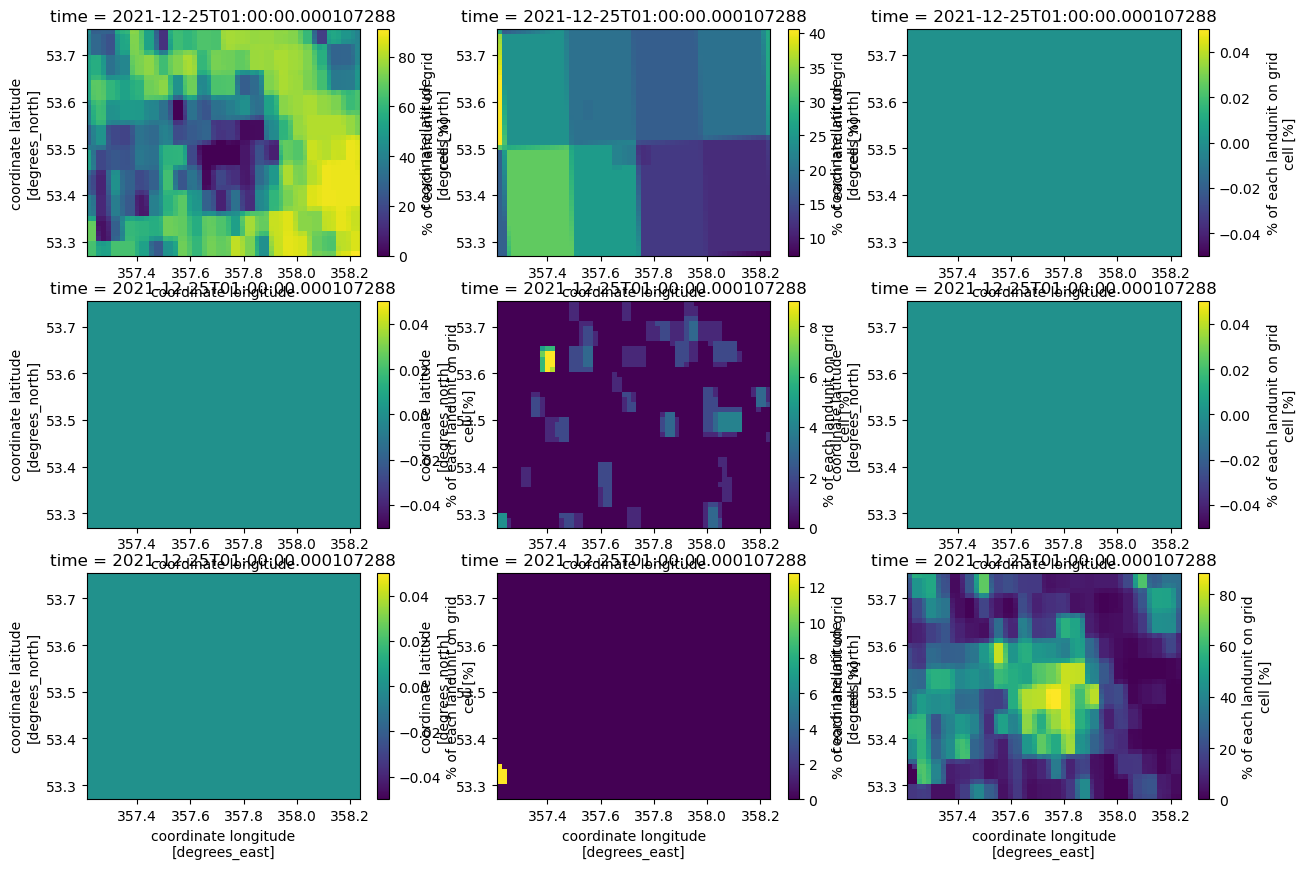

In [126]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
ax = axes.flatten()
for i in range(9):
    ds_sim['PCT_LANDUNIT'][0,i].plot(ax=ax[i])

# Observations

In [ ]:
station_data_list = []
for station in station_list:
    station_data_dir = f'observation/validation_{station}/data_for_figure/'
    df_station = pd.read_csv(f'{station_data_dir}{station}_obs.csv')
    df_station['station'] = station
    station_data_list.append(df_station)
df_obs = pd.concat(station_data_list, ignore_index=True)    
#df_obs.rename(columns={'TAS': 'TAS_obs', 'RH': 'RH_obs'}, inplace=True)
df_obs.to_csv(f'./data_for_figure/obs.csv', index=False)
df_obs

,time,TAS,RH,WIND,station
0,2022-01-01 00:00:00,13.000000,81.153014,2.6,hadisd
1,2022-01-01 01:00:00,13.000000,87.051121,3.6,hadisd
2,2022-01-01 02:00:00,13.000000,87.051121,3.6,hadisd
3,2022-01-01 03:00:00,13.000000,87.051121,2.6,hadisd
4,2022-01-01 04:00:00,13.000000,81.153014,4.1,hadisd
...,...,...,...,...,...
33763,2022-12-31 19:00:00,9.459280,93.899324,NaN,sensor
33764,2022-12-31 20:00:00,9.120794,93.965868,NaN,sensor
33765,2022-12-31 21:00:00,8.714747,92.233187,NaN,sensor
33766,2022-12-31 22:00:00,8.348432,92.049609,NaN,sensor


In [128]:
#model_list2 = ['obs'] + model_list + ['ctsm_lilac']
#model_list2 = ['obs'] + model_list
model_list2 = ['obs', 'wrf', 'wrf-ctsm']
df_merge = pd.DataFrame()
for m, model in enumerate(model_list2):
    station_data_dir = f'./data_for_figure/'
    df = pd.read_csv(f'{station_data_dir}{model}.csv')
    if m==0:
        df_merge = df
    else:
        df_merge = pd.merge(df_merge, df, on=['station', 'time'], how='outer', suffixes=('', f'_{model}'))    
df_merge.rename(columns={'TAS': 'TAS_obs', 'RH': 'RH_obs', 'WIND': 'WIND_obs'}, inplace=True)
df_merge.loc[df_merge['TAS_obs'].isna(), ['TAS_wrf', 'TAS_wrf-ctsm']] = np.nan
df_merge.loc[df_merge['RH_obs'].isna(), ['RH_wrf', 'RH_wrf-ctsm']] = np.nan
df_merge.loc[df_merge['WIND_obs'].isna(), ['WIND_wrf', 'WIND_wrf-ctsm']] = np.nan
df_merge.to_csv('./data_for_figure/merged_data.csv', index=False)
df_merge

,time,TAS_obs,RH_obs,WIND_obs,station,TAS_wrf,RH_wrf,WIND_wrf,TAS_wrf-ctsm,RH_wrf-ctsm,WIND_wrf-ctsm
0,2022-01-01 00:00:00,13.000000,81.153014,2.600000,hadisd,12.483551,92.304764,6.215323,12.749115,90.818756,5.360440
1,2022-01-01 01:00:00,13.000000,87.051121,3.600000,hadisd,12.167511,92.512993,6.551469,12.536041,90.493980,5.537817
2,2022-01-01 02:00:00,13.000000,87.051121,3.600000,hadisd,12.134491,90.631203,7.758633,12.415405,89.124199,6.485768
3,2022-01-01 03:00:00,13.000000,87.051121,2.600000,hadisd,12.104614,88.701210,8.339851,12.375153,87.249580,7.023479
4,2022-01-01 04:00:00,13.000000,81.153014,4.100000,hadisd,12.014893,87.071274,8.254773,12.245209,85.874214,6.914871
...,...,...,...,...,...,...,...,...,...,...,...
35039,2022-12-31 20:00:00,9.127000,99.953000,4.400667,whitworth,10.129241,85.680859,6.744396,10.375750,83.894046,5.739734
35040,2022-12-31 21:00:00,8.678833,99.052167,4.975333,whitworth,9.886119,86.179697,5.783938,10.178965,84.189568,5.045157
35041,2022-12-31 22:00:00,8.494833,97.091333,4.078500,whitworth,9.634945,86.589937,4.924959,9.979470,84.375373,4.425676
35042,2022-12-31 23:00:00,8.509833,95.318167,4.938667,whitworth,9.400078,86.723360,4.289187,9.775304,84.443688,3.743306


In [ ]:
df_merge['time'].duplicate

In [110]:
print((df_merge['TAS_wrf-ctsm'] == df_merge['TAS_ctsm_lilac']).all())

False


In [129]:
#df_all_hour = df_merge.dropna(subset=['TAS_wrf-ctsm', 'TAS_ctsm_lilac']).copy()
df_all_hour = df_merge.copy()
df_all_hour['time'] = pd.to_datetime(df_all_hour['time'])
df_all_hour['hour'] = df_all_hour['time'].dt.hour
df_all_hour.drop(columns=['time'], inplace=True)
df_all_hour_mean = df_all_hour.groupby(['station', 'hour']).mean().reset_index()
df_all_hour_mean.to_csv('./data_for_figure/diurnal_mean.csv', index=False)
df_all_hour_mean.head()

,station,hour,TAS_obs,RH_obs,WIND_obs,TAS_wrf,RH_wrf,WIND_wrf,TAS_wrf-ctsm,RH_wrf-ctsm,WIND_wrf-ctsm
0,hadisd,0,9.427778,85.412278,2.436389,9.700556,79.891989,4.247520,9.509342,81.504017,2.901626
1,hadisd,1,9.174515,86.169746,2.481163,9.378943,81.369811,4.145826,9.197343,82.845775,2.846134
2,hadisd,2,8.917355,87.456813,2.407163,9.132435,82.540104,4.016994,8.953618,83.867710,2.755622
3,hadisd,3,8.670330,87.913510,2.413462,8.846683,83.576965,3.916244,8.669769,84.866137,2.692805
4,hadisd,4,8.490411,88.670329,2.410685,8.642313,84.519627,3.907339,8.489461,85.639630,2.699082


In [130]:
df_all_month = df_merge.copy()
#df_all_month = df_all.dropna(subset=['TAS_wrf-ctsm', 'TAS_ctsm_lilac']).copy()
df_all_month['time'] = pd.to_datetime(df_all_month['time'])
df_all_month['month'] = df_all_month['time'].dt.month
df_all_month.drop(columns=['time'], inplace=True)
df_all_month_mean = df_all_month.groupby(['station', 'month']).mean().reset_index()
df_all_month_mean.to_csv('./data_for_figure/monthly_mean.csv', index=False)
df_all_month_mean.head()

,station,month,TAS_obs,RH_obs,WIND_obs,TAS_wrf,RH_wrf,WIND_wrf,TAS_wrf-ctsm,RH_wrf-ctsm,WIND_wrf-ctsm
0,hadisd,1,4.822581,87.305436,2.981183,4.437572,88.450765,3.907143,4.699762,87.563577,2.984410
1,hadisd,2,6.770833,82.545599,5.495387,7.005918,79.245976,7.272530,7.311687,77.957233,5.972927
2,hadisd,3,8.079301,72.631350,2.835215,8.411208,69.254576,4.525889,8.328930,71.758356,3.450980
3,hadisd,4,9.194444,70.867362,3.355278,9.806391,64.356146,4.609469,9.893415,66.089360,3.441452
4,hadisd,5,12.747312,76.793325,3.074462,13.481340,66.671205,4.701826,13.703759,67.008821,3.715542
